# **Importing all required libraries**

In [1]:

import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import to_categorical
from keras.preprocessing import image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from zipfile import ZipFile
from matplotlib import cm

Setting up GPUs

In [2]:
#GPU setting
%reload_ext autoreload
%autoreload 2
%matplotlib inline
# Import os to set the environment variable CUDA_VISIBLE_DEVICES
import os
# Set CUDA_DEVICE_ORDER so the IDs assigned by CUDA match those from nvidia-smi
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
# Set CUDA_VISIBLE_DEVICES to mask out all other GPUs than the first available device id
os.environ["CUDA_VISIBLE_DEVICES"] = "0"


# **Setting up Parameters**




In [3]:
IMG_DIRECTORY = "/content/images"
IMG_SIZE = (270, 270)
INPUT = 270
EPOCH = 10
BATCH_SIZE = 256
CLASSES = [0, 1, 2, 3, 4, 5, 6, 7, 8]
class_names = ['Chinee Apple',
               'Lantana',
               'Parkinsonia',
               'Parthenium',
               'Prickly Acacia',
               'Rubber Vine',
               'Siam Weed',
               'Snake Weed',
               'Negatives']

In [5]:
#Unzipping images from drive
with ZipFile('/content/drive/MyDrive/images.zip', "r") as f: f.extractall('/content/images')
print("Finished unzipping images.")

Finished unzipping images.


In [6]:
train_dataframe = pd.read_csv('/content/drive/MyDrive/labels/train_subset1.csv')
train_dataframe['Label'] = train_dataframe['Label'].astype(str)  

In [ ]:
train_dataframe['Label'].unique()

array(['5', '1', '0', '3', '8', '6', '4', '7', '2'], dtype=object)

In [7]:
val_dataframe = pd.read_csv('/content/drive/MyDrive/labels/val_subset0.csv')
val_dataframe['Label'] = val_dataframe['Label'].astype(str)  

In [ ]:
val_dataframe['Label'].unique()

array(['8', '4', '1', '6', '7', '0', '5', '3', '2'], dtype=object)

# **Image Generator**

In [8]:
from keras.preprocessing.image import ImageDataGenerator

# create a new generator
imagegen = ImageDataGenerator()
# load train data
train = imagegen.flow_from_dataframe(train_dataframe, IMG_DIRECTORY, 
                                     x_col='Filename',
                                     y_col='Label',
                                     class_mode="categorical", shuffle=False, batch_size=BATCH_SIZE, target_size=IMG_SIZE)
# load val data
val = imagegen.flow_from_dataframe(val_dataframe, IMG_DIRECTORY,
                                   x_col='Filename',
                                   y_col='Label',
                                   class_mode="categorical", shuffle=False, batch_size=BATCH_SIZE,target_size=IMG_SIZE)

Found 10504 validated image filenames belonging to 9 classes.
Found 3501 validated image filenames belonging to 9 classes.


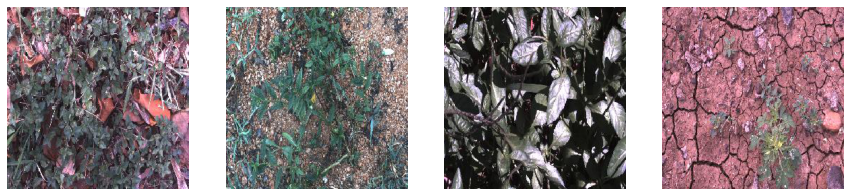

In [ ]:
# plotting some images training dataset
fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(15,15))
for i in range(4):
  # convert to unsigned integers for plotting
  image = next(train)[0].astype('uint8')
  # changing size from (1, 200, 200, 3) to (200, 200, 3) for plotting the image
  image = np.squeeze(image)

  # plot raw pixel data
  ax[i].imshow(image[i])
  ax[i].axis('off')

# **Building a sequential model**

In [12]:

from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer, BatchNormalization, Dropout
model = Sequential()
model.add(InputLayer(input_shape=(INPUT, INPUT, 3)))

# 1st conv block
model.add(Conv2D(32, (3, 3), activation='relu', strides=(1, 1), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
# 2nd conv block
model.add(Conv2D(64, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(BatchNormalization())
# 3rd conv block
model.add(Conv2D(128, (3, 3), activation='relu', strides=(2, 2), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='valid'))
model.add(BatchNormalization())
# ANN block
model.add(Flatten())
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=100, activation='relu'))
model.add(Dropout(0.25))
# output layer
model.add(Dense(units=9, activation='softmax'))

# compile model
# compile model
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])


model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 270, 270, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 135, 135, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 68, 68, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 34, 34, 64)        0         
_________________________________________________________________
batch_normalization (BatchNo (None, 34, 34, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 17, 17, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 128)         0

In [58]:
model.fit(train, epochs=EPOCH, validation_data=val)

Epoch 1/10
42/42 [==============================] - 40s 886ms/step - loss: 1.6767 - accuracy: 0.4873 - val_loss: 1.7309 - val_accuracy: 0.5247
Epoch 2/10
42/42 [==============================] - 37s 869ms/step - loss: 1.3287 - accuracy: 0.5555 - val_loss: 1.5048 - val_accuracy: 0.5501
Epoch 3/10
42/42 [==============================] - 36s 845ms/step - loss: 1.1482 - accuracy: 0.6068 - val_loss: 1.3600 - val_accuracy: 0.5847
Epoch 4/10
42/42 [==============================] - 37s 869ms/step - loss: 1.0226 - accuracy: 0.6520 - val_loss: 1.2516 - val_accuracy: 0.5967
Epoch 5/10
42/42 [==============================] - 37s 870ms/step - loss: 0.9337 - accuracy: 0.6810 - val_loss: 1.1078 - val_accuracy: 0.6410
Epoch 6/10
42/42 [==============================] - 35s 844ms/step - loss: 0.8101 - accuracy: 0.7199 - val_loss: 1.1342 - val_accuracy: 0.6495
Epoch 7/10
42/42 [==============================] - 37s 871ms/step - loss: 0.7108 - accuracy: 0.7668 - val_loss: 0.8779 - val_accuracy: 0.7241

# Printing Accuracy

In [ ]:
_, train_acc = model.evaluate(train)
print('Training Accuracy: ', train_acc)
_, validation_acc = model.evaluate(val)
print('Validation Accuracy: ', validation_acc)

42/42 [==============================] - 25s 587ms/step - loss: 0.0240 - accuracy: 0.9934
Training Accuracy:  0.9934310913085938
14/14 [==============================] - 8s 585ms/step - loss: 0.9411 - accuracy: 0.8292
Validation Accuracy:  0.8291916847229004


In [ ]:
_ ,baseline_model_accuracy = model.evaluate(
    val, verbose=0)

print('Baseline test accuracy:', baseline_model_accuracy)

Baseline test accuracy: 0.8291916847229004


# **Prediction**

In [59]:
predict = model.predict(val,3507)

# **Prediction of Each class using confusion matrix**

In [ ]:
#Confution Matrix and Classification Report
from sklearn.metrics import classification_report, confusion_matrix
#Y_pred = model.predict_generator(val, num_of_test_samples // batch_size+1)
y_pred = np.argmax(predict, axis=1)
print('Confusion Matrix')
print(confusion_matrix(y_true, y_pred))
print('Classification Report')
target_names = class_names
print(classification_report(val.classes, y_pred, target_names=target_names))

Confusion Matrix
[[ 161    9    1    2    0   18    0   18   16]
 [  11  135    0    0    0   36   11    8   12]
 [   7    4  156    3    3    2   13    8   10]
 [  17    7   21  128    2    8    2    5   14]
 [  12    6   23   13  126    4    5   11   12]
 [   6    5    1    1    1  174    2    8    4]
 [   2    6    0    0    0   29  157    2   19]
 [  19    4    2    1    0   11    1  155   10]
 [  42   24   41   14    7  216  138   64 1275]]
Classification Report
                precision    recall  f1-score   support

  Chinee Apple       0.58      0.72      0.64       225
       Lantana       0.68      0.63      0.65       213
   Parkinsonia       0.64      0.76      0.69       206
    Parthenium       0.79      0.63      0.70       204
Prickly Acacia       0.91      0.59      0.72       212
   Rubber Vine       0.35      0.86      0.50       202
     Siam Weed       0.48      0.73      0.58       215
    Snake Weed       0.56      0.76      0.64       203
     Negatives       0.

# **Function for predicting the images with correct labels**

In [60]:
predicted_class_indices=np.argmax(predict,axis=1)
y_pred = predicted_class_indices
y_true = val.classes

In [ ]:
X_test, y_test = val.next()
#X_test = np.squeeze(X_test)

In [ ]:
def plot_image(i, prediction_array, true_label, img):
  prediction_array, true_label, img = prediction_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_labels = np.argmax(prediction_array)
  if predicted_labels == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})". format(class_names[predicted_labels], 100*np.max(prediction_array),
                                      class_names[true_label]),
                                      color=color)
  

def plot_value_array(i, prediction_array, true_label):
  prediction_array, true_label = prediction_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  #plt.bar(range(9), prediction_array,  label='Prediction%')
  thisplot = plt.bar(range(9), prediction_array, color='#777777')
  plt.ylim([0,1])
  predicted_labels = np.argmax(prediction_array)

  thisplot[predicted_labels].set_color('red')
  thisplot[true_label].set_color('green')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


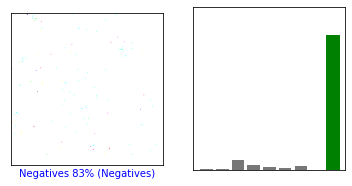

In [ ]:
i=13
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i,predict,y_true,X_test)
plt.subplot(1,2,2)
plot_value_array(i, predict,y_true)
plt.show()

# **Pruning**

In [9]:
pip install tensorflow-model-optimization

     |████████████████████████████████| 174kB 30.6MB/s 


In [10]:
X_train, y_train = train.next()

In [13]:
import tensorflow_model_optimization as tfmot

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 10 epochs.
batch_size = BATCH_SIZE
epochs = EPOCH
validation_split = 0.1 # 10% of training set will be used for validation set. 

num_images = X_train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_images / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.80,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

model_for_pruning.summary()

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/base_layer.py:2281: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
prune_low_magnitude_conv2d ( (None, 270, 270, 32)      1762      
_________________________________________________________________
prune_low_magnitude_max_pool (None, 135, 135, 32)      1         
_________________________________________________________________
prune_low_magnitude_conv2d_1 (None, 68, 68, 64)        36930     
_________________________________________________________________
prune_low_magnitude_max_pool (None, 34, 34, 64)        1         
_________________________________________________________________
prune_low_magnitude_batch_no (None, 34, 34, 64)        257       
_________________________________________________________________
prune_low_magnitude_conv2d_2 (None, 17, 17, 128)       147586    
_________________________________________________________________
prune_low_magnitude_max_pool (None, 8, 8, 128)         1

In [14]:
import tempfile
logdir = tempfile.mkdtemp()

callbacks = [
  tfmot.sparsity.keras.UpdatePruningStep(),
  tfmot.sparsity.keras.PruningSummaries(log_dir=logdir),
]

model_for_pruning.fit(X_train, y_train,
                  batch_size=batch_size, epochs=epochs, validation_split=validation_split,
                  callbacks=callbacks)
                  

Epoch 1/10
1/1 [==============================] - 38s 38s/step - loss: 2.5966 - accuracy: 0.0826 - val_loss: 26.2799 - val_accuracy: 0.0769
Epoch 2/10
1/1 [==============================] - 1s 1s/step - loss: 1.5380 - accuracy: 0.5130 - val_loss: 13.7474 - val_accuracy: 0.0769
Epoch 3/10
1/1 [==============================] - 0s 339ms/step - loss: 1.1656 - accuracy: 0.6522 - val_loss: 7.7144 - val_accuracy: 0.0769
Epoch 4/10
1/1 [==============================] - 0s 332ms/step - loss: 0.9089 - accuracy: 0.7261 - val_loss: 5.7898 - val_accuracy: 0.3462
Epoch 5/10
1/1 [==============================] - 0s 331ms/step - loss: 0.7348 - accuracy: 0.7478 - val_loss: 6.1604 - val_accuracy: 0.4615
Epoch 6/10
1/1 [==============================] - 0s 355ms/step - loss: 0.5405 - accuracy: 0.8348 - val_loss: 6.2642 - val_accuracy: 0.4615
Epoch 7/10
1/1 [==============================] - 0s 354ms/step - loss: 0.4490 - accuracy: 0.8913 - val_loss: 6.4682 - val_accuracy: 0.3846
Epoch 8/10
1/1 [======

## Interpretability Lime

In [54]:
from keras.applications import inception_v3 as inc_net
from keras.applications.vgg16 import decode_predictions
from tensorflow.keras.preprocessing import image

In [16]:
inet_model = inc_net.InceptionV3()

96116736/96112376 [==============================] - 1s 0us/step


In [55]:
def transform_img_fn(path_list):
    out = []
    for img_path in path_list:
        img = image.load_img(img_path, target_size=(270, 270))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = inc_net.preprocess_input(x)
        out.append(x)
    return np.vstack(out)

Chinee Apple
[8.5142165e-01 1.8826157e-02 3.0265417e-04 8.8961155e-04 4.2600726e-04
 7.5848470e-04 8.5916389e-03 1.1742048e-01 1.3633501e-03]


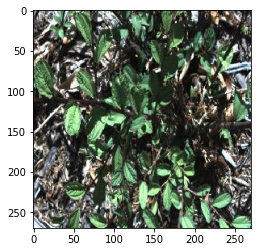

In [113]:
images = transform_img_fn([os.path.join('/content/images/','20160928-141355-0.jpg')])
# I'm dividing by 2 and adding 0.5 because of how this Inception represents images
plt.imshow(images[0] / 2 + 0.5)
preds =model_for_pruning.predict(images)
predicted_labels = np.argmax(preds)
print(class_names[predicted_labels])
#inet_model
# model_for_pruning
for x in preds:
  print(np.array(x))
#inet_model)

In [ ]:
predicted_class_indices=np.argmax(predict,axis=1)
y_pred = predicted_class_indices
y_true = val.classes

In [64]:
X_test, y_test = val.next()
X_test = np.squeeze(X_test)

In [85]:
def decode_image(i, prediction_array, true_label, img):
  prediction_array, true_label, img = prediction_array[i], true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  plt.imshow(img, cmap=plt.cm.binary)

  predicted_labels = np.argmax(prediction_array)

  #for x in prediction_array:
  print(class_names[predicted_labels], 100*np.max(prediction_array),
                                      class_names[true_label])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


1


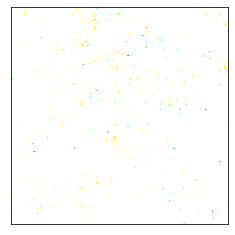

In [86]:
i=45
decode_image(i, predict, y_true, X_test)

In [47]:
! pip install lime

     |████████████████████████████████| 276kB 30.3MB/s 
  Created wheel for lime: filename=lime-0.2.0.1-cp37-none-any.whl size=283846 sha256=799231a4a792ad0a026888cb9973f7cd6625348216fdff2e4ec36eba5ab5ac6a
  Stored in directory: /root/.cache/pip/wheels/4c/4f/a5/0bc765457bd41378bf3ce8d17d7495369d6e7ca3b712c60c89
Successfully built lime


In [ ]:
%load_ext autoreload
%autoreload 2
import os,sys
try:
    import lime
except:
    sys.path.append(os.path.join('..', '..')) # add the current directory
    import lime
from lime import lime_image

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
explainer = lime_image.LimeImageExplainer()

In [ ]:
%%time
# Hide color is the color for a superpixel turned OFF. Alternatively, if it is NONE, the superpixel will be replaced by the average of its pixels
explanation = explainer.explain_instance(X_test[30].astype('double'), model.predict, top_labels=9, hide_color=0, num_samples=300)


CPU times: user 9.99 s, sys: 789 ms, total: 10.8 s
Wall time: 10.4 s


In [ ]:
from skimage.segmentation import mark_boundaries

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


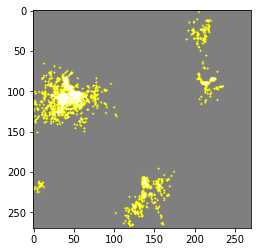

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=5, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


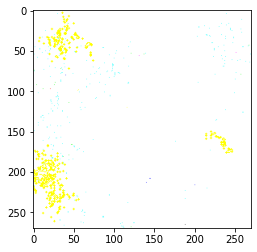

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


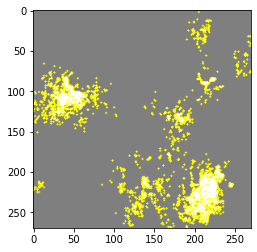

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=10, hide_rest=True)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


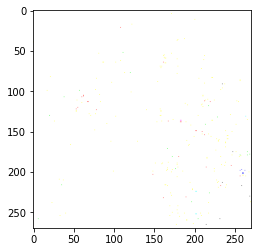

In [ ]:
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features=1000, hide_rest=False, min_weight=0.1)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))

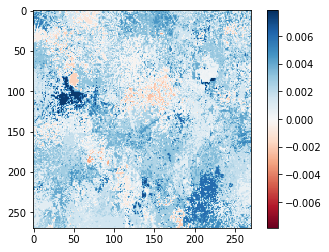

In [ ]:
#Select the same class explained on the figures above.
ind =  explanation.top_labels[0]

#Map each explanation weight to the corresponding superpixel
dict_heatmap = dict(explanation.local_exp[ind])
heatmap = np.vectorize(dict_heatmap.get)(explanation.segments) 

#Plot. The visualization makes more sense if a symmetrical colorbar is used.
plt.imshow(heatmap, cmap = 'RdBu', vmin  = -heatmap.max(), vmax = heatmap.max())
plt.colorbar()

In [48]:
import lime
from lime import lime_image
from skimage.segmentation import mark_boundaries
import matplotlib.pyplot as plt
import random

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


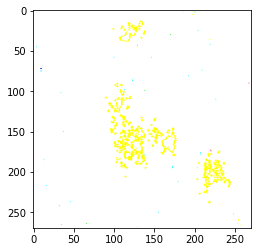

In [50]:
explainer = lime_image.LimeImageExplainer(random_state=42)
explanation = explainer.explain_instance(
         X_train[10], 
         model_for_pruning.predict
)
plt.imshow(X_train[10])
image, mask = explanation.get_image_and_mask(
         model_for_pruning.predict(
              X_train[10].reshape((1,270,270,3))
         ).argmax(axis=1)[0],
         positive_only=True, 
         hide_rest=False)
plt.imshow(mark_boundaries(image, mask))

In [ ]:
fig, ax = plt.subplots(5, 6, sharex='col', sharey='row')
fig.set_figwidth(20)
fig.set_figheight(16)
indecies = random.sample(range(sum(predict)), 5)
for j in range(5):
    explanation = explainer.explain_instance(X[bad_predictions][indecies[j]], 
                                             model.predict, 
                                             top_labels=5, hide_color=0, num_samples=1000, 
                                             random_seed=42)
    ax[j,0].imshow(X[bad_predictions][indecies[j]])
    ax[j,0].set_title(le.classes_[y[bad_predictions][indecies[j]]])
    for i in range(5):
        temp, mask = explanation.get_image_and_mask(i, positive_only=True, 
                                                    num_features=5, hide_rest=True)
        ax[j,i+1].imshow(mark_boundaries(temp / 2 + 0.5, mask))
        ax[j,i+1].set_title('p({}) = {:.4f}'.format(le.classes_[i], y_pred_train[bad_predictions][indecies[j]][i]))